In [1]:
#@title License
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A basic MNIST example using JAX with the mini-libraries stax and optimizers.

The mini-library jax.example_libraries.stax is for neural network building, and
the mini-library jax.example_libraries.optimizers is for first-order stochastic
optimization.
"""

'A basic MNIST example using JAX with the mini-libraries stax and optimizers.\n\nThe mini-library jax.example_libraries.stax is for neural network building, and\nthe mini-library jax.example_libraries.optimizers is for first-order stochastic\noptimization.\n'

In [2]:
#@title Imports
import time
import itertools

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from google.colab import files
import time

!pip install alive_progress
from alive_progress import alive_bar

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

## Hyperparameters
Let's get a few bookkeeping items out of the way.

In [4]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Auto-batching predictions

Let us first define our prediction function. Note that we're defining this for a _single_ image example. We're going to use JAX's `vmap` function to automatically handle mini-batches, with no performance penalty.

In [5]:
nonlinearity = "relu"

In [6]:
from jax.scipy.special import logsumexp
from jax.nn import sigmoid

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    if nonlinearity == 'relu':
      activations = relu(outputs)
    elif nonlinearity == "sigmoid":
      activations = sigmoid(outputs)
    else:
      raise ValueError(f'{nonlinearity} not supported')
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

Let's check that our prediction function only works on single images.

In [7]:
layer_sizes = [784, 512, 512, 10]
# layer_sizes = [784, 24, 24, 10]
step_size = 0.1
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [8]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [9]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [10]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


At this point, we have all the ingredients we need to define our neural network and train it. We've built an auto-batched version of `predict`, which we should be able to use in a loss function. We should be able to use `grad` to take the derivative of the loss with respect to the neural network parameters. Last, we should be able to use `jit` to speed up everything.

## Utility and loss functions

In [11]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def accuracy_and_predictions(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  correct_or_not = predicted_class == target_class
  return jnp.mean(correct_or_not), correct_or_not

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

## Data Loading with PyTorch

JAX is laser-focused on program transformations and accelerator-backed NumPy, so we don't include data loading or munging in the JAX library. There are already a lot of great data loaders out there, so let's just use them instead of reinventing anything. We'll grab PyTorch's data loader, and make a tiny shim to make it work with NumPy arrays.

In [12]:
!pip install torch torchvision

In [13]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [14]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [15]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Training Loop

In [16]:
def get_sizes(l):
  """Get size of arrays in tuples in list"""
  return [[x.shape for x in y] for y in l]

def get_flat(list_tuple_array):
  """Flatten all parameters or gradients"""
  return jnp.concatenate([jnp.concatenate([x[0].flatten(), x[1].flatten()]) for x in list_tuple_array])

def get_hvp(f, flat_params, v, x, y):
  return grad(lambda flat_params: jnp.vdot(get_flat(grad(f)(flat_params, x, y)), v))(flat_params)

In [17]:
def power_alg(hvp_fn, flat_v, iters=10):
  hvp_v = hvp_fn(flat_v)
  flat_hvp_v = get_flat(hvp_v)
  normed_hvp_v = flat_hvp_v/jnp.linalg.norm(flat_hvp_v)
  if iters == 0:
    return jnp.dot(flat_v, flat_hvp_v), normed_hvp_v

  return power_alg(hvp_fn, normed_hvp_v, iters=iters-1)

In [18]:
num_epochs = 20
LOG_DATA = False
LOG_EVERY = 25

In [19]:
layer_sizes = [784, 512, 512, 10]
# layer_sizes = [784, 24, 24, 10]
step_size = 0.1
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [20]:
def get_h_eig1(params, x, y, iters=20):
  flat_params = get_flat(params)
  flat_v = np.random.rand(*flat_params.shape)
  hvp = get_hvp(loss, params, flat_v, x, y)
  hvp_fn = lambda flat_v: get_hvp(loss, params, flat_v, x, y)

  eig1, eigvec1 = power_alg(hvp_fn, flat_v, iters=iters)
  return eig1, eigvec1

In [20]:
log = []
for epoch in range(num_epochs):
  start_time = time.time()
  for i, (x, y) in enumerate(training_generator):
    y = one_hot(y, n_targets)
    params = update(params, x, y)

    if LOG_DATA:
      if i % LOG_EVERY == 0:
        
        eig1, eigvec1 = get_h_eig1(params, x, y, iters=20)
        # train_acc = accuracy(params, train_images, train_labels)
        train_acc, train_correct_or_not = accuracy_and_predictions(params, train_images, train_labels)
        test_acc = accuracy(params, test_images, test_labels)
        log.append({'step': i, 
                    'epoch': epoch, 
                    'eig1': float(eig1),
                    'train': float(train_acc),
                    'test': float(test_acc),}
                  )

  epoch_time = time.time() - start_time

  train_acc, train_correct_or_not = accuracy_and_predictions(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))
  if LOG_DATA:
    print('Eig1: ', eig1)
  print('')

  

Epoch 0 in 17.30 sec
Training set accuracy 0.9541666507720947
Test set accuracy 0.949999988079071

Epoch 1 in 8.42 sec
Training set accuracy 0.9732666611671448
Test set accuracy 0.9663999676704407

Epoch 2 in 8.44 sec
Training set accuracy 0.9847500324249268
Test set accuracy 0.9738999605178833

Epoch 3 in 8.40 sec
Training set accuracy 0.989983320236206
Test set accuracy 0.9763000011444092

Epoch 4 in 8.42 sec
Training set accuracy 0.9916000366210938
Test set accuracy 0.9771999716758728

Epoch 5 in 8.39 sec
Training set accuracy 0.9940333366394043
Test set accuracy 0.9787999987602234

Epoch 6 in 14.03 sec
Training set accuracy 0.9947666525840759
Test set accuracy 0.9783999919891357

Epoch 7 in 10.63 sec
Training set accuracy 0.9966833591461182
Test set accuracy 0.9789999723434448

Epoch 8 in 8.36 sec
Training set accuracy 0.9977166652679443
Test set accuracy 0.979699969291687

Epoch 9 in 8.36 sec
Training set accuracy 0.9996166825294495
Test set accuracy 0.9821999669075012

Epoch 10 i

In [21]:
def plot_energy(params, train_images, train_labels, num_examples=500):
  def get_energy(idxs, params, eigvec1, x, y):
    energy_log = []
    with alive_bar(len(idxs)) as bar:
      for i, idx in enumerate(idxs):
        bar()
        ex = x[idx][None, :]
        ey = y[idx][None, :]
        # 2. The gradient at the examples
        egrad = grad(loss)(params, ex, ey)

        # 3. top k eigvec of H 
        flat_egrad = get_flat(egrad)
        eproj1 = np.dot(flat_egrad, eigvec1) * eigvec1

        # 4. ✨ energy ✨
        eenergy = np.linalg.norm(eproj1) / np.linalg.norm(flat_egrad)
        energy_log.append(eenergy)
    return energy_log
    
  startt = time.time()
  eig1, eigvec1 = get_h_eig1(params, train_images, train_labels, iters=10)
  print(time.time()-startt)

  # 1. list of datapoints that are misclassified
  wrong_idxs = np.where(~train_correct_or_not)[0]
  if len(wrong_idxs) > 0:
    num_wrong_examples = np.max(num_examples)
    sub_wrong_idxs = np.random.choice(wrong_idxs, num_wrong_examples)
    wrong_energy = get_energy(sub_wrong_idxs, params, eigvec1, train_images, train_labels)
    plt.hist(wrong_energy, label='wrong', alpha=0.5)

  right_idxs = np.where(train_correct_or_not)[0]
  sub_right_idxs = np.random.choice(right_idxs, num_examples)
  right_energy = get_energy(sub_right_idxs, params, eigvec1, train_images, train_labels)

  plt.hist(right_energy, label='right', alpha=0.5)
  plt.legend()
  return {'right': right_energy, 'wrong': wrong_energy}, eigvec1

In [22]:
layer_sizes = [784, 512, 512, 10]
# layer_sizes = [784, 24, 24, 10]
step_size = 0.1
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [23]:
log = []
log_energies = []
log_eigvec1 = {}


Epoch 0 in 19.49 sec
Training set accuracy 0.9541666507720947
Test set accuracy 0.949999988079071

168.95136308670044
|████████████████████████████████████████| 500/500 [100%] in 17.4s (28.78/s) 
|████████████████████████████████████████| 500/500 [100%] in 15.8s (31.71/s) 
Epoch 1 in 8.69 sec
Training set accuracy 0.9732666611671448
Test set accuracy 0.9663999676704407

Epoch 2 in 8.54 sec
Training set accuracy 0.9847500324249268
Test set accuracy 0.9738999605178833

154.98668813705444
|████████████████████████████████████████| 500/500 [100%] in 15.6s (32.15/s) 
|████████████████████████████████████████| 500/500 [100%] in 15.7s (31.78/s) 
Epoch 3 in 8.73 sec
Training set accuracy 0.989983320236206
Test set accuracy 0.9763000011444092

Epoch 4 in 8.75 sec
Training set accuracy 0.9916000366210938
Test set accuracy 0.9771999716758728

155.5820631980896
|████████████████████████████████████████| 500/500 [100%] in 15.5s (32.17/s) 
|████████████████████████████████████████| 500/500 [100%] in

UnboundLocalError: ignored

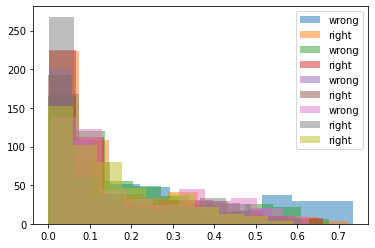

In [24]:
for epoch in range(num_epochs):
  start_time = time.time()
  for i, (x, y) in enumerate(training_generator):
    y = one_hot(y, n_targets)
    params = update(params, x, y)

  epoch_time = time.time() - start_time

  train_acc, train_correct_or_not = accuracy_and_predictions(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))
  if LOG_DATA:
    print('Eig1: ', eig1)
  print('')

  if epoch in [0, 2, 4, 8, 16]:
    energies, eigvec1 = plot_energy(params, train_images, train_labels)
    log_energies.append(energies)

In [1]:
for epoch, energies in zip([0, 5, 10, 15], log_energies):
  plt.hist(energies['right'], label='right', alpha=0.5)
  plt.hist(energies['wrong'], label='wrong', alpha=0.5)
  plt.title(epoch)
  plt.legend()

  plt.show()

NameError: ignored

In [ ]:
import pandas as pd

In [ ]:
new_log_energies = []
for epoch, energies in zip([0, 5, 10, 15], log_energies):
  for t, energy in energies.items():
    if t == 'epoch':
      continue
    for e in energy:
      new_log_energies.append({'epoch': epoch, 'class': t, 'energy': e})


In [ ]:
df = pd.DataFrame(new_log_energies)

In [ ]:
sns.boxplot(x='class', y='energy', hue='epoch', data=df)

In [ ]:
sns.violinplot(x='class', y='energy', hue='epoch', data=df)

In [27]:
# Power law

def power_alg_k(hvp_fn, flat_v, eigvecs=None, iters=10):
  hvp_v = hvp_fn(flat_v)
  flat_hvp_v = get_flat(hvp_v)

  if eigvecs is not None:

    if len(flat_v.shape) == 1:
      flat_v = flat_v[:, None]
    if len(flat_hvp_v.shape) == 1:
      flat_hvp_v = flat_hvp_v[:, None]
    foo = eigvecs.T @ flat_v
    foo = eigvecs @ foo
    shifted_hvp_v = (flat_hvp_v - foo)

  else:
    shifted_hvp_v = flat_hvp_v

  normed_shifted_hvp_v = shifted_hvp_v /jnp.linalg.norm(shifted_hvp_v)

  if iters == 0:
    return jnp.dot(flat_v.T, flat_hvp_v), normed_shifted_hvp_v

  return power_alg_k(hvp_fn, normed_shifted_hvp_v, eigvecs=eigvecs, iters=iters-1)

def get_hvp(f, flat_params, v, x, y):
  return grad(lambda flat_params: jnp.vdot(get_flat(grad(f)(flat_params, x, y)), v))(flat_params)

def get_h_eigk(params, x, y, topk=5, iters=20):

  eigs = []
  eigvecs = []

  flat_params = get_flat(params)
  flat_v = np.random.rand(*flat_params.shape)
  hvp = get_hvp(loss, params, flat_v, x, y)
  hvp_fn = lambda flat_v: get_hvp(loss, params, flat_v, x, y)

  for k in range(topk):
    if eigvecs:
      np_eigvecs = jnp.asarray(eigvecs).T
    else:
      np_eigvecs = None
    eig, eigvec = power_alg_k(hvp_fn, flat_v, np_eigvecs, iters=iters)

    eigs.append(float(eig))
    eigvecs.append(eigvec.reshape([1, -1]))

  return eigs, eigvecs
eigs, eigvecs = get_h_eigk(params, x[:5, :], y[:5, :], topk=1, iters=10)


In [29]:
eigs

[155.87806701660156]

## Plots

In [ ]:
df = pd.DataFrame(log)

In [ ]:
#@title [plot] largest eig v. step v. epoch
sns.set_context(context='talk')
f = plt.figure()
sns.lineplot(data=df, x='step', y='eig1', hue='epoch', markers=True,
             legend=False)
plt.ylabel('Largest $\lambda$')

figname = f"{nonlinearity}_mnist_lambda-v-step.pdf"
f.savefig(figname, bbox_inches='tight')
files.download(figname) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

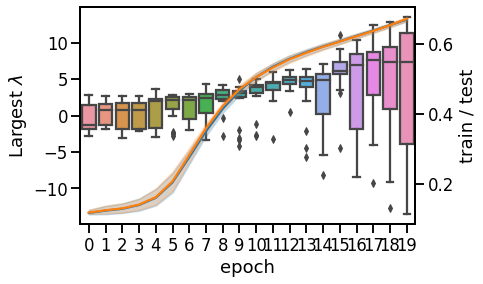

In [ ]:
#@title [plot] largest eig v. epoch 
f = plt.figure()
sns.boxplot(data=df, x='epoch', y='eig1')
plt.ylabel('Largest $\lambda$')
ax2 = plt.twinx()
sns.lineplot(data=df, x='epoch', y='train', palette=sns.color_palette("Blues", as_cmap=True), ax=ax2)
sns.lineplot(data=df, x='epoch', y='test', palette=sns.color_palette("Greens", as_cmap=True), ax=ax2)
plt.ylabel('train / test')

figname = f"{nonlinearity}_mnist_lambda-v-epoch.pdf"
f.savefig(figname, bbox_inches='tight')
files.download(figname) 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simpler application

In [33]:
from jax import jacfwd, jacrev


In [ ]:
W = jnp.array([1, 1])
b = jnp.array([3, 3])


In [31]:
key = random.PRNGKey(0)

In [32]:
# Outputs probability of a label being true.
def predict(W, b, inputs):
    return jnp.dot(inputs, W) + b

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(params, inputs, targets):
  for W, b in params: # assumes 1 layer
    preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, (1,))

def get_params(W, b):
  return [[W, b]]

params = get_params(W, b)

In [29]:
def get_flat(grads):
  return jnp.concatenate([jnp.concatenate([x[0].flatten(), x[1].flatten()]) for x in grads])

def get_hvp(f, params, v, x, y):
  return grad(lambda params: jnp.vdot(get_flat(grad(f)(params, x, y)), v))(params)

In [ ]:
print(get_sizes(params))
grads = grad(loss)(params, inputs, targets)
print(get_sizes(grads))
flat_grad = get_flat(grads)
print(flat_grad.shape)
flat_v = np.random.rand(*flat_grad.shape)
print(v.shape)

[[(3,), (1,)]]
[[(3,), (1,)]]
(4,)
(4,)


In [ ]:
hvp = get_hvp(loss, params, v, inputs, targets)

In [ ]:
def power_alg(hvp_fn, flat_v, iters=10):
  hvp_v = hvp_fn(flat_v)
  flat_hvp_v = get_flat(hvp_v)
  if iters == 0:
    return jnp.dot(flat_v, flat_hvp_v)
  normed_hvp_v = flat_hvp_v/jnp.linalg.norm(flat_hvp_v)
  return power_alg(hvp_fn, normed_hvp_v, iters=iters-1)

hvp_fn = lambda v: get_hvp(loss, params, flat_v, inputs, targets)
eig1 = power_alg(hvp_fn, v, iters=10)

In [ ]:
eig1

DeviceArray(26.773132, dtype=float32)